**Import Library**
---

In [103]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from pathlib import Path
import matplotlib.pyplot as plt
import kagglehub
import os

**Data Understanding**
---



Data yang digunakan adalah dataset rating terhadap film dari MovieLens Latest Dataset (recommended for education and development) (URL: https://grouplens.org/datasets/movielens/).

In [104]:
# Download file zip dari URL
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

# Ekstrak isi file ZIP
!unzip -o ml-latest-small.zip

--2025-06-18 12:52:17--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.2’

ml-latest-small.zip 100%[===================>] 955.28K   953KB/s    in 1.0s    

2025-06-18 12:52:19 (953 KB/s) - ‘ml-latest-small.zip.2’ saved [978202/978202]

Archive:  ml-latest-small.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Selanjutnya, mari kita baca data-data di atas dengan menggunakan fungsi pandas.read_csv. Implementasikan kode berikut.

In [105]:
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

print('Jumlah data film: ', len(movies.movieId.unique()))
print('Jumlah data link film: ', len(links.movieId.unique()))
print('Jumlah data tag pada film yang diberikan pengguna: ', len(tags.tag.unique()))
print('Jumlah data penilaian yang diberikan pengguna: ', len(ratings))

Jumlah data film:  9742
Jumlah data link film:  9742
Jumlah data tag pada film yang diberikan pengguna:  1589
Jumlah data penilaian yang diberikan pengguna:  100836


Variabel-variabel pada MovieLens Latest Dataset adalah sebagai berikut:

- movies : merupakan metadata film
- links : merupakan ID link film di imdb.com dan themoviedb.com
- tags : merupakan tag pada film yang diberikan pengguna

Data yang terlihat relatif cukup sedikit, namun kita hanya akan mengambil sampel berdasarkan movieId dan userId dari ratings.csv. Selanjutnya, mari kita melakukan eksplorasi terhadap data dengan teknik univariate exploratory data analysis.

**EDA - Univariate Analysis (movies)**

Pertama, mari kita eksplorasi variabel movies, yaitu metadata film. Mari kita lihat kolom yang terdapat pada movies menggunakan fungsi info().

In [106]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Berdasarkan output di atas, kita dapat mengetahui bahwa terdapat 9742 film yang ada pada dataset tersebut. Berikut adalah penjelasan dari kolom yang ada:
- `movieId` : identifier unik untuk setiap film
- `title` : judul film
- `genres` : genre film

Untuk melihat sampel datanya, mari kita terapkan fungsi head()

In [107]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Berdasarkan output di atas, satu film bisa terdiri dari beberapa genre yang dipisahkan oleh tanda '|'. Untuk mengetahui ada genre apa saja pada data tersebut, terapkan kode berikut:

In [108]:
# Pecah genre berdasarkan '|', lalu flatten dan ambil yang unik
unique_genres = set()

for genre_list in movies['genres']:
    genres_split = genre_list.split('|')
    unique_genres.update(genres_split)

# Tampilkan hasil
print(f"Terdapat {len(unique_genres)} jenis genre:")
print(sorted(unique_genres))

Terdapat 20 jenis genre:
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


Terdapat 20 jenis genre berbeda dengan nama genre seperti terlihat pada output kode. Perhatikanlah jenis-jenis genre di atas. Pada tahap selanjutnya kita akan gunakan data genre ini untuk memprediksi top-N rekomendasi bagi pengguna.

Naumn, terdapat nilai kolom genre = (no genres listed), artinya ada film yang genrenya tidak diketahui. Maka dari itu, kita akan memeriksa terlebih dahulu ada berapa film dengan kondisi tersebut. Terapkan kode berikut.

In [109]:
# Filter film yang tidak memiliki genre (no genres listed)
no_genre_movies = movies[movies['genres'] == '(no genres listed)']

# Tampilkan jumlah baris
print(f"Jumlah film yang tidak memiliki genre (no genres listed): {len(no_genre_movies)}")

Jumlah film yang tidak memiliki genre (no genres listed): 34


Jumlah 34 film jika dibandingkan dengan jumlah keseluruhan, yaitu 9742 film terbilang tidak signifikan. Maka dari itu, pada proses Data Preprocessing, data tersebut akan dihilangkan. Selanjutnya, kita eksplorasi variabel links, yaitu link dari film yang ada.

**EDA - Univariate Analysis (links)**

Kedua, mari kita eksplorasi variabel links, yaitu ID link film di imdb.com dan themoviedb.com. Mari kita lihat kolom yang terdapat pada links menggunakan fungsi info().

In [110]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


Berikut adalah penjelasan dari kolom yang ada:
- `movieId` : merupakan nilai identifier pada URL: https://movielens.org/movies/{movieId}
- `imdbId` :  merupakan nilai identifier pada URL: http://www.imdb.com/title/{imdbId}
- `tmdbId` : merupakan nilai identifier pada URL: https://www.themoviedb.org/movie/{tmdbId}.

Pada kolom tmdbId, terdapat 8 baris yang kosong, namun karena kolom ini tidak diikutsertakan dalam proses perhitungan, maka dapat kita biarkan saja. Untuk melihat sampel datanya, mari kita terapkan fungsi head().

In [111]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Berdasarkan output baris pertama, movieId = 1 memiliki link movielens https://movielens.org/movies/1, link imdb http://www.imdb.com/title/114709, dan link tmdb https://www.themoviedb.org/movie/862. Demikian seterusnya.

**EDA - Univariate Analysis (tags)**

Selanjutnya, kita eksplorasi variabel tags, yaitu tag pada film yang diberikan pengguna. Mari kita lihat kolom yang terdapat pada tags menggunakan fungsi info().

In [112]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Berikut adalah penjelasan dari kolom yang ada:
- `userId` : merupakan user yang memberikan tag pada film
- `movieId` :  merupakan film yang diberi tag oleh user
- `tag` : merupakan tag yang diberikan oleh user
- `timestamp` : merupakan waktu ketika pengguna memberikan tag terhadap sebuah film. Nilainya berupa angka dalam format UNIX timestamp, yaitu jumlah detik sejak 1 Januari 1970 (epoch time)

Untuk melihat sampel datanya, mari kita terapkan fungsi head()

In [113]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Baris ke-1 dari output di atas memberikan arti bahwa user dengan userId = 2 memberikan tag 'funny' ke film dengan movieId = 60756 pada 24 Oktober 2015 pukul 14:49:54 UTC (setelah dikonversi dari UNIX timestamp). Demikian seterusnya.

Selanjutnya, kita eksplorasi variabel user. Namun, pada dataset ini user tidak memiliki file .csv nya sendiri. Pada ratings.csv, terdapat kolom userId, kolom ini akan kita gunakan untuk mengidentifikasi jumlah user yang telah memberikan rating terhadap film. Terapkan kode berikut.

**EDA - Univariate Analysis (user)**

In [114]:
print('Jumlah user yang memberikan rating: ', len(ratings.userId.unique()))

Jumlah user yang memberikan rating:  610


Berdasarkan output di atas, diketahui terdapat 610 user yang telah memberikan rating terhadap film. Data ini akan digunakan untuk tahap modelling dengan Collaborative Filtering.

**EDA - Univariate Analysis (ratings)**

Selanjutnya, mari kita eksplorasi data yang akan kita gunakan pada model yaitu data ratings. Pertama, kita lihat seperti apa data pada variabel rating dengan fungsi head().

In [115]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Dari fungsi rating.head(), kita dapat mengetahui bahwa data rating terdiri dari 4 kolom. Kolom-kolom tersebut antara lain:

- `userId` : merupakan ID user
- `movieId` : merupakan ID film
- `rating` : merupakan data rating yang diberikan user terhadap film
- `timestamp` : merupakan waktu ketika pengguna memberikan rating terhadap sebuah film. Nilainya berupa angka dalam format UNIX timestamp, yaitu jumlah detik sejak 1 Januari 1970 (epoch time)

Untuk melihat distribusi rating pada data, gunakan fungsi describe() dengan menerapkan kode berikut:

In [116]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Dari output di atas, diketahui bahwa terdapat 100836 total rating dan nilai maksimum rating adalah 5 dan nilai minimumnya adalah 0.5. Artinya, skala rating berkisar antara 0.5 hingga 5.

Sampai di tahap ini, kita telah memahami variabel-variabel pada data yang kita miliki.

**Data Preprocessing - Memeriksa Missing Value pada Rating**

Untuk memeriksa apakah terdapat missing value, jalankan kode berikut.

In [117]:
# Cek missing value dengan fungsi isnull()
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


Tidak ada missing value yang ditemukan, kita dapat lanjut ke tahap berikutnya.

**Data Preprocessing - Menggabungkan Data Rating dengan Fitur Genre Film**

Langkah selanjutnya adalah menggabungkan variabel ratings dengan variabel movies, yaitu metadata film yang mengandung judul film dan genrenya. Implementasikan kode berikut.

In [118]:
# Menggabungkan dataframe ratings dengan movies dan memasukkannya ke dalam variabel movies_ratings
movies_ratings = pd.merge(ratings, movies, on='movieId', how='left')
movies_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


Inilah data yang akan kita gunakan untuk membuat sistem rekomendasi. Namun, sebagai trivia, kita akan mencari tahu film apa yang memiliki rating tertinggi, jalankan kode berikut:

In [119]:
movies_ratings[['movieId', 'title', 'rating']].groupby(['movieId', 'title']).sum().reset_index().sort_values(by='rating', ascending=False)

,movieId,title,rating
277,318,"Shawshank Redemption, The (1994)",1404.0
314,356,Forrest Gump (1994),1370.0
257,296,Pulp Fiction (1994),1288.5
1938,2571,"Matrix, The (1999)",1165.5
510,593,"Silence of the Lambs, The (1991)",1161.0
...,...,...,...
6646,57326,In the Name of the King: A Dungeon Siege Tale ...,0.5
6528,54768,Daddy Day Camp (2007),0.5
6537,54934,"Brothers Solomon, The (2007)",0.5
8966,138798,Joe Dirt 2: Beautiful Loser (2015),0.5


Film yang paling banyak mendapatkan rating adalah film The Shawshank Redemption (1994) dengan jumlah rating 1404. Sebaliknya, film yang paling sedikit mendapatkan jumlah rating adalah fillm Lionheart (1990) dengan jumlah rating 0.5.

Berikutnya, mari kita menuju tahapan Data Preparation.

**Data Preparation**
---



**Mengatasi Missing Value**

Pada tahap EDA - Univariate Analysis (movies), kita mendapat informasi 'Jumlah film yang tidak memiliki genre (no genres listed): 34'. Informasi tersebut akan kita tangani dalam tahap ini, yaitu dengan cara menghapus baris yang memiliki genre '(no genres listed)'. Terapkan kode berikut.

In [120]:
# Drop baris dengan 'genres' = '(no genres listed)'
movies_ratings = movies_ratings[movies_ratings['genres'] != '(no genres listed)']
movies_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


Perhatikanlah, setelah sebelumnya data movies_ratings memiliki 100836 baris, sekarang menjadi 100789 baris.

Mari kita cek kembali datanya apakah ada missing value atau tidak. Jalankan kode berikut.

In [121]:
# Mengecek missing value pada dataframe movies_ratings
movies_ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


Ok, sekarang data kita sudah bersih. Mari lanjutkan ke tahap berikutnya.

**Mempersiapkan Data Rating**

Dalam sistem rekomendasi berbasis Collaborative Filtering, penting untuk memastikan satu film memiliki satu baris nilai genre (bisa terdiri dari satu genre atau beberapa genre yang dipisahkan oleh tanda '|'). Tujuannya agar sistem dapat merekomendasikan film yang mirip dengan yang disukai user sebelumnya dan tidak terjadi dobel atau rangkap kategori dalam satu film. Dalam model CF, kita hanya butuh 1 baris per film untuk mengambil fitur filmnya — tidak perlu semua rating dari user. Maka dari itu, kita perlu menghapus nilai kolom movieId yang duplikat dari dataframe movie_ratings.

Berikutnya, kita bisa melanjutkan ke tahap persiapan. Buatlah variabel bernama preparation untuk persiapan yang mengambil data movies_ratings dari tahap sebelumnya.

In [122]:
# Membuat variabel preparation yang berisi dataframe movies_ratings
preparation = movies_ratings
preparation.sort_values('movieId')

,userId,movieId,rating,timestamp,title,genres
72453,469,1,4.0,965336888,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
89904,584,1,5.0,834987643,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
60405,391,1,3.0,1032388077,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
83535,533,1,5.0,1424753740,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
56878,380,1,5.0,1493420345,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
27256,184,193581,4.0,1537109082,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
27257,184,193583,3.5,1537109545,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
27258,184,193585,3.5,1537109805,Flint (2017),Drama
27259,184,193587,3.5,1537110021,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Selanjutnya, kita hanya akan menggunakan data unik untuk dimasukkan ke dalam proses pemodelan. Oleh karena itu, kita perlu menghapus data yang duplikat dengan fungsi drop_duplicates(). Dalam hal ini, kita membuang data duplikat pada kolom ‘movieId’. Implementasikan kode berikut.

In [123]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100820,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100821,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100823,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100827,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


Selanjutnya, kita perlu melakukan konversi data series menjadi list. Dalam hal ini, kita menggunakan fungsi tolist() dari library numpy. Implementasikan kode berikut.

In [124]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()

# Mengonversi data series ‘title’ menjadi dalam bentuk list
movie_title = preparation['title'].tolist()

# Mengonversi data series ‘genres’ menjadi dalam bentuk list
movie_genres = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_title))
print(len(movie_genres))

9690
9690
9690


Tahap berikutnya, kita akan membuat dictionary untuk menentukan pasangan key-value pada data movie_id, movie_title, dan movie_genres yang telah kita siapkan sebelumnya.

In [125]:
# Membuat dictionary untuk data ‘movie_id’, ‘movie_title’, dan ‘movie_genres’
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_title': movie_title,
    'movie_genres': movie_genres
})
movie_new

,id,movie_title,movie_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,6,Heat (1995),Action|Crime|Thriller
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...
9685,160341,Bloodmoon (1997),Action|Thriller
9686,160527,Sympathy for the Underdog (1971),Action|Crime|Drama
9687,160836,Hazard (2005),Action|Drama|Thriller
9688,163937,Blair Witch (2016),Horror|Thriller


Pahami terlebih dahulu data rating yang kita miliki. Ingatlah saat kita melakukan load data di awal dan membaca file rating_final.csv. Saat itu, kita membuat variabel rating dan menetapkan data pada variabel tersebut. Kemudian, kita menghapus rating pada data film dengan genres = '(no_genres_listed)' dan menyimpannya dalam variabel movies_ratings. Untuk memudahkan supaya tidak tertukar dengan fitur ‘rating’ pada data, kita ubah nama variabel movies_ratings (tanpa kolom genres dan title) menjadi variabel df.

In [126]:
# Membaca dataset
df = movies_ratings.drop(['genres', 'title'], axis=1)
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


**Encoding userId dan movieId**

Sekarang data rating memiliki 100789 baris dan 4 kolom. Sekarang kita memasuki tahap encoding userId dan movieId. Pada tahap ini, kita perlu melakukan persiapan data untuk menyandikan (encode) fitur ‘userId’ dan ‘movieId’ ke dalam indeks integer. Terapkan kode berikut.

In [127]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Selanjutnya, lakukan hal yang sama pada fitur ‘movieId’.

In [128]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

Berikutnya, petakan userId dan movieId ke dataframe yang berkaitan.

In [129]:
# Mapping userId ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe movie
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

Terakhir, cek beberapa hal dalam data seperti jumlah user, jumlah film, dan mengubah nilai rating menjadi float.

In [130]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah film
num_movie = len(movie_to_movie_encoded)
print(num_movie)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

610
9690
Number of User: 610, Number of Movie: 9690, Min Rating: 0.5, Max Rating: 5.0


Tahap persiapan telah selesai. Berikut adalah hal-hal yang telah kita lakukan pada tahap ini:

- Memahami data rating yang kita miliki.
- Menyandikan (encode) fitur ‘userId’ dan ‘movieId’ ke dalam indeks integer.
- Memetakan ‘userID’ dan ‘movieId’ ke dataframe yang berkaitan.
- Mengecek beberapa hal dalam data seperti jumlah user, jumlah film, kemudian mengubah nilai rating menjadi float.

Tahap persiapan ini penting dilakukan agar data siap digunakan untuk
pemodelan. Namun sebelumnya, kita perlu membagi data untuk training dan validasi terlebih dahulu.

**Train & Validation Split**

Sebelum membagi data menjadi data training dan validasi, datanya perlu diacak terlebih dahulu agar distribusinya menjadi random.

In [131]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
980,7,8665,3.5,1108602755,6,783
64486,414,42728,3.5,1163775855,413,5917
80543,509,6377,3.5,1435992322,508,875
50593,326,85342,4.5,1322252028,325,5844
64557,414,48304,4.0,1184683869,413,1049
...,...,...,...,...,...,...
6266,42,4007,5.0,996258563,41,1189
54910,365,508,2.0,1488594826,364,656
76849,480,7376,1.0,1179165684,479,5869
860,6,981,3.0,845556567,5,712


- frac=1 berarti "fraction" = 100% dari data diambil, tapi urutannya diacak.
- random_state=42 berarti menetapkan seed untuk pengacakan, agar hasil acakan selalu sama setiap kali dijalankan. Angka 42 bisa diganti berapa pun, tapi disarankan untuk tetap konsisten agar replikasi bisa dilakukan.

Selanjutnya, kita bagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, kita perlu memetakan (mapping) data user dan film menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [132]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[   6  783]
 [ 413 5917]
 [ 508  875]
 ...
 [ 479 5869]
 [   5  712]
 [ 102 1129]] [0.66666667 0.66666667 0.66666667 ... 0.11111111 0.55555556 0.88888889]


Kode tersebut digunakan untuk mempersiapkan data sebelum dimasukkan ke dalam model dengan cara memisahkan fitur dan label, melakukan normalisasi rating, serta membagi data menjadi data latih dan validasi. Pertama, `x = df[['user', 'movie']].values` mengambil kolom hasil encoding user dan movie sebagai fitur input dan mengubahnya menjadi array NumPy. Kemudian, `y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values` menormalisasi nilai rating agar berada dalam rentang 0 hingga 1, yang mempermudah proses pelatihan model. Selanjutnya, `train_indices = int(0.8 * df.shape[0])` menghitung jumlah baris yang digunakan untuk data latih berdasarkan 80% dari total data. Terakhir, data dibagi menjadi `x_train, x_val, y_train, dan y_val` menggunakan slicing berdasarkan indeks tersebut, dan `print(x, y)` digunakan untuk menampilkan isi array input dan label yang telah diproses.

Data telah siap untuk dimasukkan ke dalam model untuk dievaluasi.

**Modelling**
---

Pada Collaborative Filtering, pendekatan yang digunakan berfokus pada pola interaksi antara pengguna dan film. Kita perlu melakukan encoding data pengguna dan film, membagi data menjadi training dan testing, lalu melatih model menggunakan data tersebut. Setelah pelatihan selesai, model akan dievaluasi untuk mengetahui seberapa baik kemampuannya dalam memahami preferensi pengguna dan memberikan rekomendasi film yang relevan.

Collaborative Filtering mampu menemukan pola yang lebih kompleks dari pada model Content Based Filtering dalam perilaku pengguna dan dapat merekomendasikan item di luar preferensi konten sebelumnya. Namun, model ini memerlukan data interaksi yang cukup besar agar akurat, dan dapat mengalami masalah cold start ketika menghadapi pengguna atau item baru yang belum memiliki cukup data.

Pada tahap ini, model menghitung skor kecocokan antara user dan film dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan film. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan film. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan film. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

Di sini, kita membuat class RecommenderNet dengan keras Model class. Kode class RecommenderNet ini terinspirasi dari tutorial dalam situs Keras dengan beberapa adaptasi sesuai kasus yang sedang kita selesaikan. Terapkan kode berikut.

In [133]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Pada tahap ini, model menghitung skor kecocokan antara user dan film menggunakan teknik embedding, yang memungkinkan model merepresentasikan user dan film dalam bentuk vektor berdimensi rendah. Proses ini dilakukan oleh kelas RecommenderNet, yang merupakan turunan dari tf.keras.Model. Berikut penjelasan dari tahapannya:
1. Embedding Layer
Model membuat dua embedding layer terpisah untuk:
    - User (self.user_embedding)
    Menerjemahkan ID user menjadi vektor berdimensi embedding_size.
    - Film (self.movie_embedding)
    Menerjemahkan ID film menjadi vektor berdimensi embedding_size.

    Selain itu, model juga membuat bias embedding untuk masing-masing:
    - self.user_bias: memberikan nilai bias untuk tiap user.
    - self.movie_bias: memberikan nilai bias untuk tiap film.

2. Dot Product (Perkalian Vektor)
Pada fungsi call(), model menerima input berisi pasangan [user_id, movie_id].
Kemudian, dilakukan:
- Pengambilan embedding user dan film berdasarkan ID masing-masing.
- Pengambilan bias user dan bias film.
- Penghitungan dot product antara embedding user dan embedding film, yaitu tf.tensordot(user_vector, movie_vector, 2), yang menghasilkan skor kecocokan mentah.

3. Penambahan Bias
Hasil dot product tersebut ditambahkan dengan user_bias dan movie_bias untuk mengakomodasi preferensi atau kecenderungan masing-masing user dan film yang tidak ditangkap oleh embedding saja.

4. Aktivasi Sigmoid
Nilai akhir (skor kecocokan) dilewatkan ke fungsi aktivasi sigmoid, yang akan memetakan skor tersebut ke dalam rentang [0, 1].
Nilai ini dapat diinterpretasikan sebagai probabilitas seberapa besar kemungkinan user akan menyukai film tersebut.

Selanjutnya, lakukan proses compile terhadap model.

In [134]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini merupakan model rekomendasi sederhana yang dibangun dengan arsitektur RecommenderNet. Model ini dirancang untuk memprediksi tingkat kecocokan antara pengguna dan film berdasarkan embedding. Jumlah pengguna (num_users) dan film (num_movie) ditentukan berdasarkan dataset, dan 50 merupakan ukuran dari embedding vector yang digunakan untuk mewakili setiap pengguna dan film dalam ruang fitur laten.
Selanjutnya, model di-compile dengan beberapa parameter, yaitu:
- Loss function BinaryCrossentropy: Digunakan untuk mengukur seberapa jauh prediksi model dari nilai target sebenarnya, dalam konteks klasifikasi biner (antara user dan film).
- Optimizer Adam dengan LR = 0.001: Digunakan untuk mengupdate bobot model selama training untuk meminimalkan loss. Nilai 0.001 merupakan nilai standar yang memberikan laju pembelajaran yang stabil, tidak terlalu cepat sehingga menghindari overshooting, dan tidak terlalu lambat agar proses training efisien. Adam adalah salah satu optimizer yang paling umum karena menggabungkan kelebihan dari dua metode lainnya: AdaGrad dan RMSProp. Adam dapat menangani data yang sparse dan memiliki performa konvergensi yang baik dengan sedikit penyesuaian hyperparameter.
- Metrik evaluasi RMSE: Digunakan untuk mengevaluasi performa model selama training dan testing dengan menghitung akar dari rata-rata kuadrat selisih antara prediksi dan nilai aktual. Semakin kecil nilai RMSE, maka semakin akurat model dalam memprediksi.

RMSE adalah akar dari rata-rata kuadrat selisih antara prediksi dan nilai aktual. Cocok digunakan untuk mengukur performa sistem rekomendasi yang memprediksi angka seperti rating. Nilai RMSE yang rendah menunjukkan model yang akurat.

**Evaluasi**
---

Selanjutnya, kita akan melatih model dengan data training dan data validation yang telah ditetapkan sebelumnya dengan 25 epoch dan nilai batch size = 32. Penggunaan batch_size = 32 berarti model akan memproses 32 data sekaligus sebelum memperbarui bobotnya. Ukuran ini memberikan keseimbangan antara kecepatan training, efisiensi memori, dan akurasi pembelajaran, serta merupakan salah satu pilihan batch size yang paling umum digunakan dalam praktik deep learning. Penggunaan epoch = 25 berarti model akan dilatih selama 25 putaran penuh. Jumlah ini cukup untuk memberikan model waktu belajar yang memadai tanpa terlalu lama sehingga berisiko overfitting.

In [135]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 25,
    validation_data = (x_val, y_val)
)

Epoch 1/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.6545 - root_mean_squared_error: 0.2494 - val_loss: 0.6159 - val_root_mean_squared_error: 0.2097
Epoch 2/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.6140 - root_mean_squared_error: 0.2074 - val_loss: 0.6115 - val_root_mean_squared_error: 0.2048
Epoch 3/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.6070 - root_mean_squared_error: 0.2016 - val_loss: 0.6087 - val_root_mean_squared_error: 0.2017
Epoch 4/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.6049 - root_mean_squared_error: 0.1988 - val_loss: 0.6079 - val_root_mean_squared_error: 0.2007
Epoch 5/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.6046 - root_mean_squared_error: 0.1981 - val_loss: 0.6073 - val_root_mean_squared_error: 0.1999
Epoch 6/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.6019 - root_mean_squared_error: 0.1955 - val_loss: 0.6076 - val_root_mean_squared_error: 0.2002
Epoch 7/25
2520/2520 ━━━━━━━━━━━━━

**Visualisasi Metrik**

Untuk melihat visualisasi proses training dan validation, mari kita plot metrik evaluasi dengan matplotlib. Terapkan kode berikut.

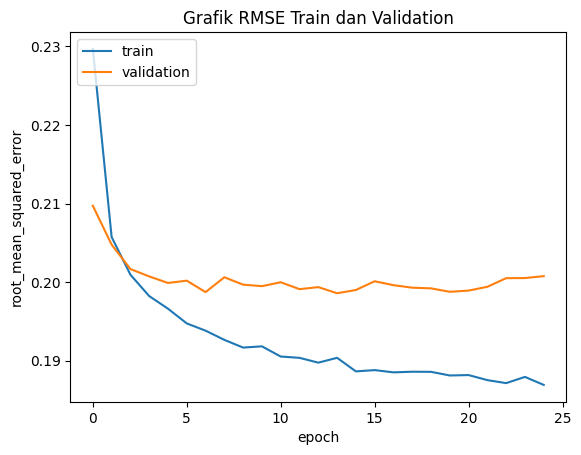

In [136]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Grafik RMSE Train dan Validation')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Sumbu x menunjukkan epoch dan sumbu y menunjukkan nilai RMSE. Perhatikanlah, proses training dan validation model cukup smooth dan model konvergen pada epochs sekitar 25. Dari proses ini, kita memperoleh nilai error akhir sebesar 0.1865 dan error pada data validasi sebesar 0.2008. Nilai tersebut cukup bagus untuk sistem rekomendasi. Mari kita cek, apakah model ini bisa membuat rekomendasi dengan baik?

**Mendapatkan Rekomendasi Film**

Untuk mendapatkan rekomendasi film, pertama kita ambil sampel user secara acak dan definisikan variabel movie_not_watched yang merupakan daftar film yang belum pernah ditonton oleh user. Daftar movie_not_watched inilah yang akan menjadi film yang kita rekomendasikan.

Sebelumnya, user telah memberi rating pada beberapa film yang telah mereka tonton. Kita menggunakan rating ini untuk membuat rekomendasi film yang mungkin cocok untuk user. Nah, film yang akan direkomendasikan tentulah film yang belum pernah ditonton oleh user. Oleh karena itu, kita perlu membuat variabel movie_not_watched sebagai daftar film untuk direkomendasikan pada user.

Variabel movie_not_watched diperoleh dengan menggunakan operator bitwise (~) pada variabel movie_watched_by_user.

Terapkan kode berikut.

In [137]:
movie_df = movie_new
df = movies_ratings.drop(['genres', 'title'], axis=1)

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

Kode tersebut bertujuan untuk menyiapkan data rekomendasi film bagi seorang pengguna secara acak. Pertama, dipilih satu userId secara acak dari dataset, lalu diambil daftar film yang sudah ditonton oleh user tersebut. Selanjutnya, digunakan operator bitwise NOT (~) untuk mendapatkan daftar film yang belum ditonton oleh user dengan membandingkan semua film yang ada di dataset. Daftar film ini kemudian disaring agar hanya mencakup film yang telah diencoding (ada di movie_to_movie_encoded), lalu setiap ID film dikonversi ke bentuk numerik. Setelah itu, ID user juga dikonversi ke bentuk numerik, dan dibentuk array pasangan user-film dalam bentuk numerik, yang siap digunakan sebagai input bagi model rekomendasi untuk memprediksi skor kecocokan antara user dan film.

Selanjutnya, untuk memperoleh rekomendasi film, gunakan fungsi model.predict() dari library Keras dengan menerapkan kode berikut.

In [138]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movies with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_title, ':', row.movie_genres)

print('----' * 8)
print('Top 10 Movies Recommendation')
print('----' * 8)

recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_title, ':', row.movie_genres)

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Showing recommendations for users: 610
Movies with high ratings from user
--------------------------------
Toy Story (1995) : Adventure|Animation|Children|Comedy|Fantasy
Heat (1995) : Action|Crime|Thriller
The Nice Guys (2016) : Crime|Mystery|Thriller
Logan (2017) : Action|Sci-Fi
Get Out (2017) : Horror
--------------------------------
Top 10 Movies Recommendation
--------------------------------
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama|Film-Noir|Romance
Ran (1985) : Drama|War
Gallipoli (1981) : Drama|War
Lawrence of Arabia (1962) : Adventure|Drama|War
His Girl Friday (1940) : Comedy|Romance
Trial, The (Procès, Le) (1962) : Drama
Five Easy Pieces (1970) : Drama
Secrets & Lies (1996) : Drama
Paths of Glory (1957) : Drama|War
Woman in the Dunes (Suna no onna) (1964) : Drama


Kita telah berhasil memberikan rekomendasi kepada user, dan sebagai contoh, hasil di atas adalah rekomendasi untuk user dengan userId 279. Dari output tersebut, kita dapat melihat dua bagian utama: "Movies with high ratings from user", yang menunjukkan daftar film yang sebelumnya diberi rating tinggi oleh user tersebut, dan "Top 10 Movies Recommendation", yang merupakan hasil rekomendasi berdasarkan preferensi user. Menariknya, banyak film yang direkomendasikan memiliki genre yang konsisten dengan preferensi genre user, seperti Drama, War, dan Documentary yang mendominasi daftar rekomendasi. Hal ini menunjukkan bahwa sistem rekomendasi berhasil mengenali pola preferensi pengguna dan memberikan saran yang relevan.

Sampai tahap ini, kita telah berhasil membangun sistem rekomendasi menggunakan teknik Collaborative Filtering, yang mengandalkan data interaksi pengguna (seperti rating) tanpa memerlukan informasi konten film secara langsung.